In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
# Splitting MNIST dataset into train and test sets
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [ ]:
def same_padding(kernel_size, stride=1):
    # For odd dimensions, we can pad evenly on both sides
    # For even dimensions, we will pad one more on the right/bottom side
    pad_val = (kernel_size - stride) // 2
    return (pad_val, pad_val + (kernel_size % 2 - 1))


def create_sparse_representations(batch, sparsity=0.5):
    # Function to create sparse representations and masks for a batch of images
    masks = torch.bernoulli(torch.ones_like(batch) * (1 - sparsity))
    sparse_batch = batch * masks
    return sparse_batch, masks


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cuda


In [ ]:
class NormalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, padding=(11-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=11, stride=1, padding=(11-1)//2),
            nn.Conv2d(16, 16, kernel_size=7, padding=(7-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=1, padding=(7-1)//2),
            nn.Conv2d(16, 16, kernel_size=5, padding=(5-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=(5-1)//2),
            nn.Conv2d(16, 16, kernel_size=3, padding=(3-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=(3-1)//2),
            nn.Conv2d(16, 16, kernel_size=3, padding=(3-1)//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=(3-1)//2),
            nn.Conv2d(16, 10, kernel_size=1, padding=(1-1)//2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bias = torch.rand_like(torch.Tensor(out_channels)).to('cuda')

    def forward(self, input, mask):
        # Create a new mask
        new_mask = F.conv2d(mask, torch.ones_like(self.conv.weight), None, self.conv.stride, self.conv.padding)
        valid_pixel_amount = new_mask.clone().detach()
        # Apply convolution to the input
        output = self.conv(input * mask) * (self.conv.kernel_size[0] * self.conv.kernel_size[1])
        output = output.div(torch.add(valid_pixel_amount, 1e-5))
        output = output + self.bias.view(1,-1,1,1)

        new_mask = torch.ceil(new_mask.clamp_(0, 1))

        return output, new_mask

class SparseInvariantCNN(nn.Module):

    def __init__(self):
      super().__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=11, padding=same_padding(11)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
        nn.Conv2d(16, 16, kernel_size=7, padding=same_padding(7)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
        nn.Conv2d(16, 16, kernel_size=5, padding=same_padding(5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 10, kernel_size=1, padding=same_padding(1)),
        nn.ReLU()
    )

    def forward(self, x, mask):
        for layer in self.features:
            if isinstance(layer, SparseConv2d):
                x, mask = layer(x, mask)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
import torch.nn.functional as F

def evaluate_mae_with_sparsity_classification(data_loader, model, sparsity_levels, device):
    model.eval()
    maes = {}

    for sparsity in sparsity_levels:
        total_mae = 0.0
        count = 0
        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)

                sparse_images, _ = create_sparse_representations(images, sparsity=sparsity)
                sparse_images = sparse_images.to(device)

                outputs = model(sparse_images)
                # Convert labels to one-hot encoding to match output shape
                labels_one_hot = F.one_hot(labels, num_classes=outputs.size(-1)).float()

                mae = torch.abs(outputs - labels_one_hot.to(device)).mean()
                total_mae += mae.item()
                count += 1

        avg_mae = total_mae / count if count > 0 else 0
        maes[sparsity] = avg_mae

    return maes

model = NormalCNN().to(device)

sparsity_levels = [0.7, 0.8, 0.9]

maes = evaluate_mae_with_sparsity_classification(test_loader, model, sparsity_levels, device)

for sparsity, mae in maes.items():
    print(f"Sparsity Level {int(sparsity*100)}%: MAE = {mae}")



Sparsity Level 70%: MAE = 0.034057199527883227
Sparsity Level 80%: MAE = 0.03368130297797501
Sparsity Level 90%: MAE = 0.033298472571335024


In [ ]:
def simplified_mae_for_classification(data_loader, model, sparsity_levels, device):
    model.eval()
    maes = {}

    for sparsity in sparsity_levels:
        total_error = 0.0
        total_count = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)

                sparse_images, _ = create_sparse_representations(images, sparsity=sparsity)
                sparse_images = sparse_images.to(device)

                # Get model outputs and convert to probabilities
                outputs = model(sparse_images)
                probabilities = F.softmax(outputs, dim=1)

                # For each item, find the probability of the true class
                true_class_probs = probabilities[torch.arange(images.size(0)), labels]

                # Calculate errors as 1 - true_class_prob
                errors = 1 - true_class_probs

                # Update total error and count
                total_error += errors.sum().item()
                total_count += errors.size(0)

        # Calculate mean absolute error for this sparsity level
        avg_error = total_error / total_count if total_count > 0 else 0
        maes[sparsity] = avg_error

    return maes
model = NormalCNN().to(device)
sparsity_levels = [0.3, 0.6, 0.9]


maes = simplified_mae_for_classification(test_loader, model, sparsity_levels, device)

for sparsity, mae in maes.items():
    print(f"Sparsity Level {int(sparsity * 100)}%: Simplified MAE = {mae}")


Sparsity Level 30%: Simplified MAE = 0.9998846664428711
Sparsity Level 60%: Simplified MAE = 0.9998847134590149
Sparsity Level 90%: Simplified MAE = 0.9998848139762878


In [ ]:
def evaluate_mae_with_sparsity_classification(data_loader, model, sparsity_levels, device):
    model.eval()
    maes = {}

    for sparsity in sparsity_levels:
        total_mae = 0.0
        count = 0
        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)


                sparse_images, masks = create_sparse_representations(images, sparsity=sparsity)
                sparse_images, masks = sparse_images.to(device), masks.to(device)

                outputs = model(sparse_images, masks)
                # Convert labels to one-hot encoding to match output shape for MAE calculation
                labels_one_hot = F.one_hot(labels, num_classes=outputs.size(-1)).float().to(device)

                mae = torch.abs(outputs - labels_one_hot).mean()
                total_mae += mae.item()
                count += 1

        avg_mae = total_mae / count if count > 0 else 0
        maes[sparsity] = avg_mae

    return maes



model2 = SparseInvariantCNN().to(device)

sparsity_levels = [0.7, 0.8, 0.9]  # Corresponding to 70%, 80%, and 90% sparsity

maes2 = evaluate_mae_with_sparsity_classification(test_loader, model2, sparsity_levels, device)

for sparsity, mae in maes2.items():
    print(f"Sparsity Level {int(sparsity*100)}%: MAE = {mae}")

Sparsity Level 70%: MAE = 0.06474743484501626
Sparsity Level 80%: MAE = 0.06485426492372136
Sparsity Level 90%: MAE = 0.06504718968822698


In [ ]:

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = NormalCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 55

def evaluate_accuracy(data_loader, net, device):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            # Assuming you still want to evaluate on sparse data
            sparse_images, _ = create_sparse_representations(images, sparsity=0.7)  # Example sparsity
            sparse_images = sparse_images.to(device)

            outputs = net(sparse_images)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    sparcity = 0.9  # Example sparsity
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Create sparse representations (assuming you're comparing performance on sparse data)
        sparse_images, _ = create_sparse_representations(images, sparsity=sparcity)
        sparse_images = sparse_images.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images)  # Adjusted to not use masks
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and log average loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, net, device) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, net, device) * 100
    test_accs.append(test_acc)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')


Epoch 1/55
Loss: 8.9674, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 2/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 3/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 4/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 5/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 6/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 7/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 8/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 9/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 10/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 11/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 12/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 13/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Accuracy: 9.80%
Epoch 14/55
Loss: 8.9670, Training Accuracy: 9.87%, Test Acc

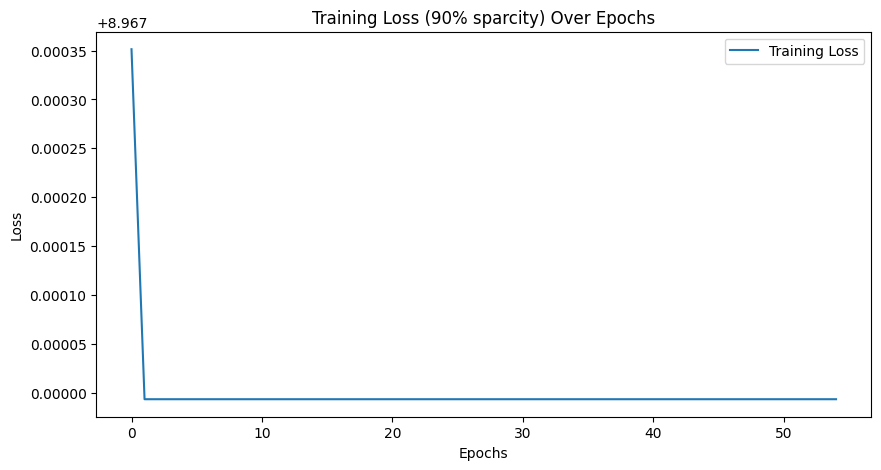

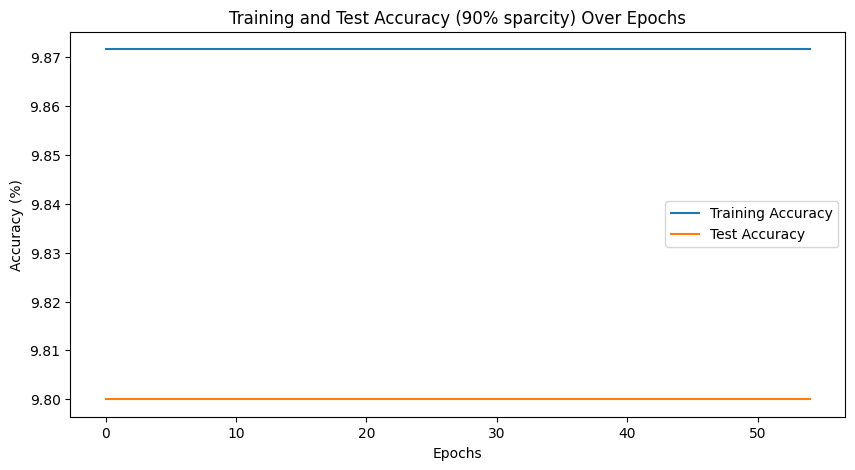

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (90% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy (90% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [ ]:
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SparseInvariantCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 55

def evaluate_accuracy(data_loader, sparcity, net):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = net(sparse_images, masks)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Training loop
for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    sparcity = 0.9
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Create sparse representations and masks
        sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
        sparse_images, masks = sparse_images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, sparcity, net) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, sparcity, net) * 100
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')


Epoch 1/55
Loss: 2.3653, Training Accuracy: 33.83%, Test Accuracy: 34.43%
Epoch 2/55
Loss: 1.6950, Training Accuracy: 43.54%, Test Accuracy: 43.57%
Epoch 3/55
Loss: 1.4967, Training Accuracy: 51.70%, Test Accuracy: 52.18%
Epoch 4/55
Loss: 1.3702, Training Accuracy: 54.43%, Test Accuracy: 54.74%
Epoch 5/55
Loss: 1.2916, Training Accuracy: 56.47%, Test Accuracy: 58.47%
Epoch 6/55
Loss: 1.2454, Training Accuracy: 59.47%, Test Accuracy: 59.18%
Epoch 7/55
Loss: 1.1949, Training Accuracy: 59.21%, Test Accuracy: 60.47%
Epoch 8/55
Loss: 1.1708, Training Accuracy: 60.85%, Test Accuracy: 61.13%
Epoch 9/55
Loss: 1.1428, Training Accuracy: 59.88%, Test Accuracy: 61.06%
Epoch 10/55
Loss: 1.1224, Training Accuracy: 63.03%, Test Accuracy: 63.76%
Epoch 11/55
Loss: 1.1064, Training Accuracy: 61.74%, Test Accuracy: 62.97%
Epoch 12/55
Loss: 1.0919, Training Accuracy: 63.14%, Test Accuracy: 64.13%
Epoch 13/55
Loss: 1.0766, Training Accuracy: 63.60%, Test Accuracy: 64.79%
Epoch 14/55
Loss: 1.0649, Training

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Apparently, implementing backward pass besides using the subclass torch.autograd.Function i.e. PyTorch's automatic differentiation engine, autograd, will handle the backward pass is better in accuracy metric